In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import pickle

# Load Data

In [2]:
import os, re
import pandas as pd

def load_raw_data(root_dir, sensors=("Accelerometer", "Gravity", "Gyroscope")):
    """
    Load raw sensor data into a nested dictionary.

    Structure:
        data[activity][trial][student][sensor] = DataFrame

    Folder naming convention:
        "{Activity}_{trial}_{student}"
        e.g. "Sit_1_Student1"

    Parameters
    ----------
    root_dir : str
        Root directory containing activity folders.
    sensors : tuple of str
        Sensor names to load (case-sensitive, must match CSV filenames).

    Returns
    -------
    dict
        Nested dictionary with DataFrames.
    """

    data = {}

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        # Match folder name pattern
        match = re.match(r"([A-Za-z]+)_(\d+)_([A-Za-z0-9]+)", folder)
        if not match:
            print(f"[load_raw_data] Skipping {folder} (unexpected name format)")
            continue

        activity, trial, student = match.groups()

        # Initialize nested dicts
        data.setdefault(activity, {}).setdefault(trial, {}).setdefault(student, {})

        # Load each sensor file if it exists
        for sensor in sensors:
            file_path = os.path.join(folder_path, f"{sensor}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                data[activity][trial][student][sensor.lower()] = df
            else:
                print(f"[load_raw_data] Missing {file_path}")

    return data


In [3]:
data = load_raw_data("Raw Data")

# Save the data dictionary to a pickle file
with open("data.pkl", "wb") as f:
    pickle.dump(data, f)

In [4]:
data["Stand"]["1"]["Student2"]["accelerometer"]   

,time,seconds_elapsed,z,y,x
0,1759335409976468500,0.082469,-0.850113,3.366333,0.248235
1,1759335409996468500,0.102469,-0.858248,3.363387,0.579521
2,1759335410006468400,0.112468,-0.946154,3.226892,0.546483
3,1759335410016468500,0.122469,-0.916845,2.890102,0.727473
4,1759335410026468400,0.132468,-0.789377,2.846688,0.188056
...,...,...,...,...,...
549,1759335415589220600,5.695221,-0.065486,-0.026914,-0.254590
550,1759335415599220700,5.705221,-0.070545,-0.014017,-0.246673
551,1759335415609220600,5.715221,0.973150,-0.368365,0.149593
552,1759335415619220700,5.725221,0.914912,-0.438314,0.223567


# 1) Data Preprocessing Pipeline

1) Time synchronization

2) Combine sensor data together

3) Trimming

4) Windowing 

5) Saving

In [5]:
import os
import re
import numpy as np
import pandas as pd

def build_synchronized_dataset(
    raw_dir="Raw Data",
    out_dir="Synchronized Data",
    fs=100.0,
    float_fmt="%.2f",
    verbose=True
):
    """
    Process all trial folders under `raw_dir`, synchronize Accelerometer/Gravity/Gyroscope to a 100 Hz
    common timeline, save CSVs, and return a nested dict:

        synced[activity][trial][student] = DataFrame (seconds_elapsed + acc_*, grav_*, gyro_*)

    Parameters
    ----------
    raw_dir : str
        Root folder that contains trial subfolders (e.g., 'Running_1_Student1').
    out_dir : str
        Root folder where synchronized data will be written mirroring the structure of raw_dir.
    fs : float
        Target sampling rate (Hz). Default 100.0.
    float_fmt : str
        CSV float formatting (for pretty decimals). Default '%.2f'.
    verbose : bool
        Print progress.

    Returns
    -------
    dict
        Nested mapping: synced[activity][trial][student] -> synchronized DataFrame.
    """
    SENSOR_FILES = {
        "Accelerometer.csv": "acc",
        "Gravity.csv":       "grav",
        "Gyroscope.csv":     "gyro",
    }

    # Parse folders like 'Running_1_Student2'
    folder_re = re.compile(r"(?P<activity>.+?)_(?P<trial>\d+)_Student(?P<student>\d+)$")

    def parse_folder(name):
        m = folder_re.match(name)
        if not m:
            # fallbacks if naming doesn't match pattern
            return name, "1", "Student1"
        g = m.groupdict()
        return g["activity"], g["trial"], f"Student{g['student']}"

    def clean(df: pd.DataFrame) -> pd.DataFrame:
        if "time" in df.columns:
            df = df.drop(columns="time")
        df["seconds_elapsed"] = pd.to_numeric(df["seconds_elapsed"], errors="coerce")
        for c in df.columns:
            if c != "seconds_elapsed":
                df[c] = pd.to_numeric(df[c], errors="coerce")
        df = df.dropna(subset=["seconds_elapsed"]).sort_values("seconds_elapsed")
        df = df.drop_duplicates(subset=["seconds_elapsed"])
        return df

    def process_one_trial(trial_dir: str) -> pd.DataFrame:
        # --- load & clean the three sensors
        loaded = {}
        for fname, pref in SENSOR_FILES.items():
            fpath = os.path.join(trial_dir, fname)
            if not os.path.exists(fpath):
                raise FileNotFoundError(f"Missing {fname} in {trial_dir}")
            df = clean(pd.read_csv(fpath))
            if df.empty:
                raise ValueError(f"{fname} empty after cleaning in {trial_dir}")
            # prefix feature cols
            df = df.rename(columns={c: f"{pref}_{c.lower()}" for c in df.columns if c != "seconds_elapsed"})
            loaded[pref] = df

        acc, grav, gyro = loaded["acc"], loaded["grav"], loaded["gyro"]

        # --- outer merge on seconds_elapsed
        merged = (
            acc.merge(grav, on="seconds_elapsed", how="outer")
               .merge(gyro, on="seconds_elapsed", how="outer")
               .sort_values("seconds_elapsed")
               .reset_index(drop=True)
        )

        # --- overlap window
        start = max(acc["seconds_elapsed"].min(), grav["seconds_elapsed"].min(), gyro["seconds_elapsed"].min())
        end   = min(acc["seconds_elapsed"].max(), grav["seconds_elapsed"].max(), gyro["seconds_elapsed"].max())
        if not (end > start):
            return pd.DataFrame()

        # --- build timeline from integer ticks to avoid float artifacts
        start_tick = int(np.ceil(start * fs))
        end_tick   = int(np.floor(end * fs))
        if end_tick <= start_tick:
            return pd.DataFrame()

        ticks = np.arange(start_tick, end_tick + 1, dtype=np.int64)
        timeline = ticks / fs  # exact hundredth-seconds

        # --- union (existing + timeline) -> interpolate -> filter to timeline
        existing = merged["seconds_elapsed"].to_numpy(dtype=float)
        union_index = np.unique(np.concatenate([existing, timeline]))
        union_df = (
            merged.set_index("seconds_elapsed")
                  .reindex(union_index)
                  .sort_index()
        )

        # numeric interpolation
        num_cols = union_df.select_dtypes(include=[np.number]).columns
        union_df[num_cols] = union_df[num_cols].interpolate(method="linear", limit_direction="both")

        # back to column, then keep only timeline rows and drop dups
        union_df = union_df.reset_index().rename(columns={"index": "seconds_elapsed"})
        aligned = union_df[union_df["seconds_elapsed"].isin(timeline)].copy()
        aligned = aligned.drop_duplicates(subset=["seconds_elapsed"], keep="first").reset_index(drop=True)

        # ensure nicely rounded seconds for display (values are already exact ticks)
        aligned["seconds_elapsed"] = (np.round(aligned["seconds_elapsed"] * fs).astype(np.int64) / fs)

        return aligned

    # --- run over all trials and save + collect into nested dict
    os.makedirs(out_dir, exist_ok=True)
    synced = {}

    for folder in sorted(os.listdir(raw_dir)):
        trial_path = os.path.join(raw_dir, folder)
        if not os.path.isdir(trial_path):
            continue

        activity, trial, student = parse_folder(folder)
        out_trial_dir = os.path.join(out_dir, folder)
        os.makedirs(out_trial_dir, exist_ok=True)

        try:
            aligned = process_one_trial(trial_path)
        except Exception as e:
            if verbose:
                print(f"[SKIP] {folder}: {e}")
            continue

        # save csv with pretty decimals
        out_csv = os.path.join(out_trial_dir, "sensor_data.csv")
        aligned.to_csv(out_csv, index=False, float_format=float_fmt)

        # stash in nested dict for immediate use
        synced.setdefault(activity, {}).setdefault(trial, {})[student] = aligned

    return synced



In [6]:
synced = build_synchronized_dataset(
    raw_dir="Raw Data",
    out_dir="Synchronized Data",
    fs=100.0,
    float_fmt="%.2f",
    verbose=True
)

synced

{'Running': {'1': {'Student1':       seconds_elapsed     acc_z     acc_y     acc_x    grav_z    grav_y  \
   0                0.05 -0.160453  0.028115 -0.106718  1.782375 -9.501895   
   1                0.06 -0.145704  0.107412 -0.049795  1.792316 -9.499789   
   2                0.07 -0.182536  0.142902 -0.025809  1.801540 -9.497872   
   3                0.08 -0.251381  0.119720 -0.052860  1.809557 -9.496237   
   4                0.09 -0.237098  0.059136 -0.154470  1.815925 -9.495060   
   ...               ...       ...       ...       ...       ...       ...   
   1304            13.09 -0.075813 -0.141096  0.102072  1.954663 -9.439826   
   1305            13.10 -0.211386 -0.268965  0.013156  1.951297 -9.439373   
   1306            13.11 -0.269847 -0.142159  0.011028  1.943693 -9.439585   
   1307            13.12  0.029439  0.003533  0.104279  1.934030 -9.439455   
   1308            13.13  0.502484 -0.002447  0.155124  1.928678 -9.437889   
   
           grav_x    gyro_z    g

In [7]:
# To drop time columns after windowing
TIME_COL_CANDS = ["seconds_elapsed"]

def _get_time_col(df):
    """
    Return the first matching time column from TIME_COL_CANDS.
    Assumes at least one of them is present.
    """
    for col in TIME_COL_CANDS:
        if col in df.columns:
            return col
    raise ValueError("No valid time column found. Expected one of: " + ", ".join(TIME_COL_CANDS))


def _crop_segment(df, start_offset_s, duration_s, time_col, hz=100.0):
    """
    For activities like Sit/Stand:
    Take a fixed segment starting at row index corresponding to start_offset_s * hz
    and keep exactly duration_s * hz samples (index-based, like window_all_100hz).

    Parameters
    ----------
    df : pd.DataFrame
    start_offset_s : float
        Offset in seconds from the *first row* of df.
    duration_s : float
        Desired window length in seconds.
    time_col : str
        Unused for filtering here (kept for API consistency).
    hz : float
        Assumed sampling rate (default 100.0 Hz).

    Returns
    -------
    pd.DataFrame
        Cropped DataFrame with reset index; empty if not enough rows.
    """
    if df is None or df.empty:
        return df

    n_off = int(round(float(start_offset_s) * float(hz)))
    n_win = int(round(float(duration_s) * float(hz)))
    if n_off < 0 or n_win <= 0:
        return df.iloc[0:0].reset_index(drop=True)

    start_idx = n_off
    end_idx = start_idx + n_win

    if start_idx >= len(df) or end_idx <= 0:
        return df.iloc[0:0].reset_index(drop=True)

    # Clamp to available range
    start_idx = max(0, start_idx)
    end_idx = min(len(df), end_idx)

    # If the clamped slice is shorter than requested window, return empty (strict)
    if end_idx - start_idx < n_win:
        return df.iloc[0:0].reset_index(drop=True)

    return df.iloc[start_idx:end_idx].reset_index(drop=True)


def _crop_trim(df, start_trim_s, end_trim_s, time_col):
    """
    For other activities:
    Trim 'start_trim_s' seconds from the beginning,
    and 'end_trim_s' seconds from the end of the recording.
    """
    t_min, t_max = float(df[time_col].min()), float(df[time_col].max())
    start_bound = t_min + float(start_trim_s)
    end_bound   = t_max - float(end_trim_s)
    # Guard: if trims remove the whole range, return empty DataFrame
    if start_bound >= end_bound:
        return df.iloc[0:0].reset_index(drop=True)
    return df[(df[time_col] >= start_bound) & (df[time_col] <= end_bound)].reset_index(drop=True)

def crop_mixed_combined(
    data_combined,
    sit_stand_start_offset_s=1.5,
    window_size_s=2.0,
    trims_start=None,
    trims_end=None,
    sit_stand_set=("Sit", "Stand"),
    hz=100.0,
    verbose=False
):
    """
    Input:
        data_combined[activity][trial][student] = DataFrame (time + all sensor cols)
    Output:
        cropped[activity][trial][student] = DataFrame (cropped)
    """
    if trims_start is None: trims_start = 2.0
    if trims_end   is None: trims_end   = 2.0

    def _resolve(activity, val):
        return val.get(activity, val.get(activity.capitalize(), 0)) if isinstance(val, dict) else val

    cropped = {}
    for activity, trials in data_combined.items():
        cropped[activity] = {}
        for trial, students in trials.items():
            cropped[activity][trial] = {}
            for student, df in students.items():
                if not isinstance(df, pd.DataFrame) or df.empty:
                    cropped[activity][trial][student] = df
                    if verbose:
                        print(f"[crop_mixed_combined] Empty: {activity}-{trial}-{student}")
                    continue

                # detect time col if present
                try:
                    tcol = _get_time_col(df)
                except ValueError:
                    tcol = None  # allow time-less data if you already index by samples

                if activity in sit_stand_set:
                    # fixed-length segment by sample count (uses hz)
                    if tcol is None:
                        # no time column needed for count-based crop
                        out = _crop_segment(df, sit_stand_start_offset_s, window_size_s, time_col="", hz=hz)
                    else:
                        out = _crop_segment(df, sit_stand_start_offset_s, window_size_s, tcol, hz=hz)
                else:
                    if tcol is None:
                        # fall back: trim by samples if no time
                        n0 = int(round(_resolve(activity, trims_start) * hz))
                        n1 = int(round(_resolve(activity, trims_end) * hz))
                        if n0 + n1 >= len(df):
                            out = df.iloc[0:0].reset_index(drop=True)
                        else:
                            out = df.iloc[n0:len(df)-n1].reset_index(drop=True)
                    else:
                        # trim by time bounds
                        s_trim = _resolve(activity, trims_start)
                        e_trim = _resolve(activity, trims_end)
                        out = _crop_trim(df, s_trim, e_trim, tcol)

                cropped[activity][trial][student] = out

    return cropped


In [8]:
def window_all_100hz_combined(
    data_combined,
    window_size_s=2.0,
    step_s=None,
    keep_time_col=True,  # keep time since you combined early
    time_col_candidates=("seconds_elapsed", "time")
):
    """
    Input:
        data_combined[activity][trial][student] = DataFrame
    Output:
        windows[activity][trial][student] = [DataFrame, ...]
    """
    HZ = 100.0
    if step_s is None:
        step_s = window_size_s

    n_win = int(round(window_size_s * HZ))
    n_stp = int(round(step_s * HZ))
    if n_win <= 0 or n_stp <= 0:
        raise ValueError("window_size_s and step_s must be > 0.")

    def _drop_time(df):
        drops = [c for c in time_col_candidates if c in df.columns]
        return df.drop(columns=drops) if (not keep_time_col and drops) else df

    def _make_windows(df):
        if df is None or df.empty: return []
        N = len(df)
        last_start = N - n_win
        if last_start < 0: return []
        out = []
        for s in range(0, last_start + 1, n_stp):
            e = s + n_win
            out.append(_drop_time(df.iloc[s:e].copy()).reset_index(drop=True))
        return out

    windows = {}
    for activity, trials in data_combined.items():
        windows[activity] = {}
        for trial, students in trials.items():
            windows[activity][trial] = {}
            for student, df in students.items():
                windows[activity][trial][student] = _make_windows(df)
    return windows


In [9]:
def save_windows_simple(
    windows,
    out_dir="windows_out"
):
    """
    Input:
        windows[activity][trial][student] = [DataFrame_win0, ...]
    """
    os.makedirs(out_dir, exist_ok=True)
    index_rows = []

    for activity, trials in windows.items():
        for trial, students in trials.items():
            for student, win_list in students.items():
                for i, wdf in enumerate(win_list):
                    rel = f"{activity}/trial_{trial}/{student}/win_{i}.csv"
                    path = os.path.join(out_dir, rel)
                    os.makedirs(os.path.dirname(path), exist_ok=True)
                    wdf.to_csv(path, index=False)
                    index_rows.append({
                        "activity": activity,
                        "trial": trial,
                        "student": student,
                        "window_idx": i,
                        "path": path
                    })

    idx = pd.DataFrame(index_rows)
    idx.to_csv(os.path.join(out_dir, "index.csv"), index=False)
    return idx


In [10]:
# 2) Crop differently by activity on the combined DF
cropped = crop_mixed_combined(
    synced,
    sit_stand_start_offset_s=1.0,
    window_size_s=2.0,
    trims_start={"Running": 2, "Walking": 2, "Stairs": 2, "Stand": 0, "Sit": 0},
    trims_end={"Running": 2, "Walking": 2, "Stairs": 2, "Stand": 0, "Sit": 0},
    sit_stand_set=("Sit", "Stand"),
    hz=100.0,
    verbose=True
)

# 3) Window the combined DF
win = window_all_100hz_combined(
    cropped,
    window_size_s=2.0,
    step_s=2.0,
    keep_time_col=True
)

# 4) Save one CSV per window
inventory = save_windows_simple(win, out_dir="windows")
print("Saved windows:", len(inventory), "→ index at:", "windows/index.csv")


Saved windows: 160 → index at: windows/index.csv


In [11]:
import matplotlib.pyplot as plt

def plot_window(window_df, activity_name="Activity"):
    """
    Plot x, y, z vs time for each sensor in a combined window DataFrame.
    Expects columns like: time, acc_x/acc_y/acc_z, gyro_x/gyro_y/gyro_z, grav_x/grav_y/grav_z
    """
    # time column
    tcol = "time" if "time" in window_df.columns else "seconds_elapsed"
    t = window_df[tcol]

    # map prefixes to nice names
    prefix_map = {
        "acc": "Accelerometer",
        "gyro": "Gyroscope",
        "grav": "Gravity"
    }

    # find which sensors exist in this DF
    sensors_present = [p for p in prefix_map if f"{p}_x" in window_df.columns]

    fig, axes = plt.subplots(len(sensors_present), 1, figsize=(7, 3*len(sensors_present)), sharex=True)
    if len(sensors_present) == 1:
        axes = [axes]

    fig.suptitle(activity_name, fontsize=14)

    for ax, pref in zip(axes, sensors_present):
        ax.plot(t, window_df[f"{pref}_x"], label="x")
        ax.plot(t, window_df[f"{pref}_y"], label="y")
        ax.plot(t, window_df[f"{pref}_z"], label="z")
        ax.set_ylabel(prefix_map[pref])
        ax.legend(loc="upper right")

    axes[-1].set_xlabel(tcol)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [12]:

# Save the win dictionary to a pickle file
with open("win.pkl", "wb") as f:
    pickle.dump(win, f)


In [13]:
#with open("win.pkl", "rb") as f:
    #win = pickle.load(f)

In [14]:
win

{'Running': {'1': {'Student1': [     seconds_elapsed      acc_z      acc_y      acc_x    grav_z    grav_y  \
    0               2.05   2.388369  -0.294773  -0.649140 -1.848926 -9.384910   
    1               2.06   2.744976  -0.192006  -0.176985 -1.864807 -9.376945   
    2               2.07   2.658726  -0.077039   0.008037 -1.869911 -9.369807   
    3               2.08   2.520719   0.085996   0.066159 -1.865980 -9.363677   
    4               2.09   2.342588   0.206946  -0.127818 -1.853797 -9.359081   
    ..               ...        ...        ...        ...       ...       ...   
    195             4.00 -15.608119 -20.415125  -0.001195 -1.109544 -9.472593   
    196             4.01 -12.516512 -25.287644  -3.829650 -1.602693 -9.354583   
    197             4.02   0.294809 -27.500811  -7.803795 -2.081407 -9.205667   
    198             4.03  13.194472 -27.134506 -14.757107 -2.393181 -9.050112   
    199             4.04  15.778745 -23.191275 -20.189716 -2.486213 -8.914744   


In [15]:
win['Running']['2']['Student1'][3]

,seconds_elapsed,acc_z,acc_y,acc_x,grav_z,grav_y,grav_x,gyro_z,gyro_y,gyro_x
0,8.04,2.342665,15.966727,4.095011,1.652210,-9.657109,0.423147,0.655778,0.981842,-0.280189
1,8.05,2.806570,16.011843,4.241468,1.638414,-9.662945,0.333253,0.826917,1.137359,-0.109684
2,8.06,2.676738,15.267404,3.538976,1.628635,-9.667741,0.220519,1.107358,1.321654,-0.196654
3,8.07,1.070247,12.847947,0.834985,1.594874,-9.675406,0.067704,1.571182,1.546073,-0.566341
4,8.08,-1.038142,9.560380,-2.607791,1.514962,-9.687272,-0.131026,1.962151,1.634318,-1.059275
...,...,...,...,...,...,...,...,...,...,...
195,9.99,2.598078,10.495202,-6.019649,-1.144498,-9.031821,3.642955,1.282275,0.688341,2.083992
196,10.00,3.121432,10.779230,-5.860874,-0.910536,-9.100969,3.534607,1.284922,1.113836,2.351726
197,10.01,4.205174,11.044005,-5.663753,-0.635794,-9.164930,3.427044,1.273475,1.516904,2.606364
198,10.02,4.300241,10.934909,-5.900066,-0.334845,-9.221708,3.315226,1.320568,1.520904,2.745339


In [16]:
win.keys()

dict_keys(['Running', 'Sit', 'Stairs', 'Stand', 'Walking'])

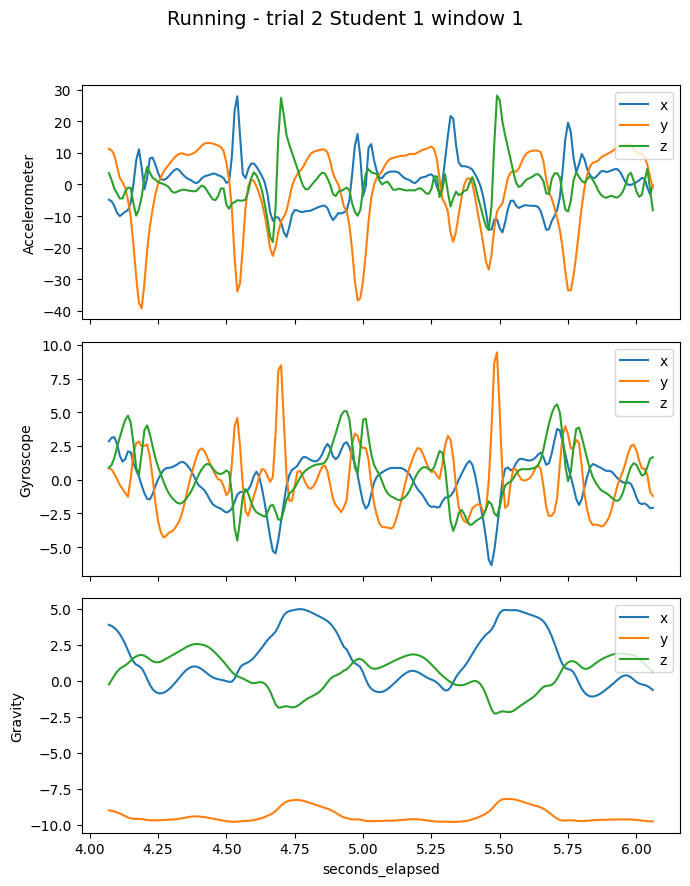

In [17]:
plot_window(win["Running"]["4"]["Student1"][1], activity_name="Running - trial 2 Student 1 window 1")


In [18]:
# Load the index file created by save_windows
idx = pd.read_csv("windows/index.csv")

# Count windows per activity
counts = idx.groupby("activity")["window_idx"].count().reset_index(name="num_windows")

print(counts)

  activity  num_windows
0  Running           18
1      Sit           30
2   Stairs           30
3    Stand           30
4  Walking           52


## Features

### List of features

- Time domain:
    - per axis for each sensor:
        - mean
        - median
        - std
        - var
        - min
        - max
        - range
        - rmn (root mean square)
        - mad (median absolute deviation)
        - iqr (interquartile range)
        - skew (distribution skewness)
        - kurt (kurtosis, peakedness)
    - per sensor:
        - sma (signal magnitude area = mean(|x|+|y|+|z|))
    - per sensor correlations

- Frequency domain:
    - per axis for each sensor:
        - dominant frequency
        - dominant magnitude
        - average spectral energy
        - spectral entropy

### Calculating Features

In [19]:
data

{'Running': {'1': {'Student1': {'accelerometer':                      time  seconds_elapsed         z         y         x
    0     1759158616638895600         0.040896 -0.165525 -0.013971 -0.128877
    1     1759158616648954400         0.050954 -0.155381  0.070200 -0.084560
    2     1759158616659012600         0.061013 -0.136026  0.144623 -0.015030
    3     1759158616669071400         0.071071 -0.229045  0.141181 -0.036587
    4     1759158616679130600         0.081131 -0.273716  0.098258 -0.069132
    ...                   ...              ...       ...       ...       ...
    1298  1759158629695364400        13.097364 -0.127062 -0.286627  0.053590
    1299  1759158629705423400        13.107423 -0.295709 -0.251304 -0.027278
    1300  1759158629715482400        13.117482 -0.243986 -0.033014  0.049334
    1301  1759158629725541400        13.127541  0.302864  0.040080  0.159224
    1302  1759158629735599600        13.137600  0.702105 -0.044975  0.151024
    
    [1303 rows x 5 columns

In [20]:
data.keys()

dict_keys(['Running', 'Sit', 'Stairs', 'Stand', 'Walking'])

In [21]:
win.keys()

dict_keys(['Running', 'Sit', 'Stairs', 'Stand', 'Walking'])

In [22]:
import os
import re
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# ------------------ Feature helpers (no band powers) ------------------
FS = 100.0
TIME_COLS = {"seconds_elapsed", "time"}

def _drop_time_cols(df):
    drop = [c for c in df.columns if c in TIME_COLS]
    return df.drop(columns=drop) if drop else df

def _find_axes(df):
    lower = {c.lower(): c for c in df.columns}
    def pick(axis):
        if axis in lower: return lower[axis]
        for c in df.columns:
            lc = c.lower()
            if lc == axis or lc.startswith(axis) or axis in lc:
                return c
        return None
    return pick("x"), pick("y"), pick("z")

def _iqr(x):  return float(np.subtract(*np.percentile(x, [75, 25]))) if x.size else np.nan
def _mad(x):
    if x.size == 0: return np.nan
    med = np.median(x); return float(np.median(np.abs(x - med)))
def _rms(x): return float(np.sqrt(np.mean(x.astype(float)**2))) if x.size else np.nan

def _dom_freq_and_mag(x, fs=FS):
    n = x.size
    if n == 0: return np.nan, np.nan
    x = x.astype(float) - np.mean(x)
    X = np.fft.rfft(x, n=n)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    amp = np.abs(X) / n
    if amp.size > 0: amp[0] = 0.0
    k = int(np.argmax(amp))
    return float(freqs[k]), float(amp[k])

def _spectral_energy_entropy(x, fs=FS):
    n = x.size
    if n == 0: return {"spec_energy": np.nan, "spec_entropy": np.nan}
    x = x.astype(float) - np.mean(x)
    X = np.fft.rfft(x, n=n)
    power = (np.abs(X)**2) / n
    power[0] = 0.0
    total_p = np.sum(power) + 1e-12
    p_norm = power / total_p
    return {
        "spec_energy": float(total_p / n),
        "spec_entropy": float(-np.sum(p_norm * np.log(p_norm + 1e-12)))
    }

def _sma(x, y=None, z=None):
    parts = [a for a in (x, y, z) if a is not None]
    if not parts: return np.nan
    S = np.zeros_like(parts[0], dtype=float)
    for a in parts: S += np.abs(a.astype(float))
    return float(np.mean(S))

def _axis_features(x, prefix):
    x = np.asarray(x).astype(float)
    feats = {
        f"{prefix}_mean":   float(np.mean(x)) if x.size else np.nan,
        f"{prefix}_median": float(np.median(x)) if x.size else np.nan,
        f"{prefix}_std":    float(np.std(x, ddof=1)) if x.size>1 else (0.0 if x.size==1 else np.nan),
        f"{prefix}_var":    float(np.var(x, ddof=1)) if x.size>1 else (0.0 if x.size==1 else np.nan),
        f"{prefix}_min":    float(np.min(x)) if x.size else np.nan,
        f"{prefix}_max":    float(np.max(x)) if x.size else np.nan,
        f"{prefix}_range":  float(np.max(x)-np.min(x)) if x.size else np.nan,
        f"{prefix}_rms":    _rms(x),
        f"{prefix}_mad":    _mad(x),
        f"{prefix}_iqr":    _iqr(x),
        f"{prefix}_skew":   float(skew(x, bias=False)) if x.size>2 else 0.0,
        f"{prefix}_kurt":   float(kurtosis(x, fisher=True, bias=False)) if x.size>3 else 0.0,
    }
    f, a = _dom_freq_and_mag(x, fs=FS)
    feats[f"{prefix}_fft_dom_freq_hz"] = f
    feats[f"{prefix}_fft_dom_mag"] = a
    feats.update({f"{prefix}_{k}": v for k,v in _spectral_energy_entropy(x, fs=FS).items()})
    return feats

def _pair_corr(a, b, name):
    a = np.asarray(a).astype(float); b = np.asarray(b).astype(float)
    if a.size < 2 or b.size < 2: return {f"{name}_corr": np.nan}
    sa, sb = np.std(a), np.std(b)
    if sa == 0 or sb == 0: return {f"{name}_corr": 0.0}
    return {f"{name}_corr": float(np.corrcoef(a, b)[0,1])}

SENSOR_ALIAS = {
    "acc": "accelerometer", "accelerometer": "accelerometer",
    "gyro": "gyroscope",    "gyroscope": "gyroscope",
    "grav": "gravity",      "gravity": "gravity",
}


def _split_merged_window(df):
    """Split a merged window into per-sensor sub-frames (accelerometer, gyroscope, gravity)."""
    time_cols = [c for c in df.columns if c in TIME_COLS]
    groups = {}
    pat = re.compile(r"^(acc|accelerometer|gyro|gyroscope|grav|gravity)_(x|y|z)$", re.IGNORECASE)

    for col in df.columns:
        if col in TIME_COLS: 
            continue
        m = pat.match(col)
        if not m: 
            continue
        alias, axis = m.group(1).lower(), m.group(2).lower()
        sensor = SENSOR_ALIAS.get(alias)
        if not sensor:
            continue
        groups.setdefault(sensor, {"x": None, "y": None, "z": None})
        groups[sensor][axis] = col

    out = {}
    for sensor, axes in groups.items():
        cols = time_cols[:]
        for a in ("x","y","z"):
            if axes[a]:
                cols.append(axes[a])
        if cols:
            sub = df[cols].copy()
            # rename to x,y,z
            rename_map = {axes[a]: a for a in ("x","y","z") if axes[a]}
            out[sensor] = sub.rename(columns=rename_map)
    return out

def features_from_window_df(df):
    """
    Auto-detect sensors in a merged CSV and compute features per sensor+axis.
    """
    blocks = _split_merged_window(df)
    feats_all = {}

    if blocks:
        for sensor, subdf in blocks.items():
            d = _drop_time_cols(subdf)
            xs = d["x"].to_numpy() if "x" in d else None
            ys = d["y"].to_numpy() if "y" in d else None
            zs = d["z"].to_numpy() if "z" in d else None

            # per-axis
            if xs is not None: feats_all |= _axis_features(xs, f"{sensor}_x")
            if ys is not None: feats_all |= _axis_features(ys, f"{sensor}_y")
            if zs is not None: feats_all |= _axis_features(zs, f"{sensor}_z")

            # magnitude
            axes = [a for a in (xs, ys, zs) if a is not None]
            if len(axes) >= 2:
                mag = np.sqrt(np.sum([a.astype(float)**2 for a in axes], axis=0))
                feats_all |= _axis_features(mag, f"{sensor}_mag")

            # SMA + correlations
            feats_all[f"{sensor}_sma"] = _sma(xs, ys, zs)
            if xs is not None and ys is not None: feats_all |= _pair_corr(xs, ys, f"{sensor}_xy")
            if xs is not None and zs is not None: feats_all |= _pair_corr(xs, zs, f"{sensor}_xz")
            if ys is not None and zs is not None: feats_all |= _pair_corr(ys, zs, f"{sensor}_yz")

        return feats_all

    # fallback if nothing matched
    d = _drop_time_cols(df)
    num = d.select_dtypes(include=[np.number]).to_numpy()
    feats = {}
    if num.size:
        feats |= _axis_features(num.ravel(), "merged_all")
        feats["merged_sma"] = float(np.mean(np.abs(num.ravel().astype(float))))
    return feats

# ------------------ Walk windows/ + build features ------------------
def _parse_from_path(rel_path):
    """
    Accepts paths like:
      Running/trial_1/Student1/win_0.csv
      Running/trial_1/Student1/accelerometer/win_0.csv
    Returns: activity, trial(str), student, sensor(str or 'merged'), window_idx(int)
    """
    parts = rel_path.replace("\\","/").split("/")
    # Expect at least: [activity, trial_#, student, ... , win_#.csv]
    if len(parts) < 4:
        return None
    activity = parts[0]
    trial = parts[1].replace("trial_","")
    student = parts[2]
    # Detect sensor folder (optional)
    if len(parts) >= 5 and parts[3] not in ("",) and not parts[3].startswith("win_"):
        sensor = parts[3]
        fname = parts[4]
    else:
        sensor = "merged"
        fname = parts[3]
    m = re.match(r"win_(\d+)\.csv$", fname)
    widx = int(m.group(1)) if m else -1
    return activity, trial, student, sensor, widx

def extract_features_from_windows_dir(root="windows"):
    """
    Read windows from disk (using index.csv if present, otherwise scan tree),
    compute features per file, and return a single DataFrame.
    """
    index_path = os.path.join(root, "index.csv")
    rows = []

    # 1) Preferred: use index.csv (created by your saver)
    if os.path.exists(index_path):
        idx = pd.read_csv(index_path)
        # Expect columns: path (absolute or relative), activity, trial, student, window_idx
        for _, r in idx.iterrows():
            path = r["path"] if "path" in r else None
            if not path or not os.path.isabs(path):
                # if stored as relative, make it relative to root
                path = os.path.join(root, os.path.relpath(path or "", start=root)) if path else None
            if not path or not os.path.exists(path):
                # Try rebuild from metadata if available
                if {"activity","trial","student","window_idx"}.issubset(idx.columns):
                    rel = f"{r['activity']}/trial_{r['trial']}/{r['student']}/win_{int(r['window_idx'])}.csv"
                    path = os.path.join(root, rel)
            if not path or not os.path.exists(path):
                continue  # skip missing

            df = pd.read_csv(path)
            feats = features_from_window_df(df)   # auto-detect sensors
            row = {
                "activity": r.get("activity", np.nan),
                "trial": str(r.get("trial", "")),
                "student": r.get("student", ""),
                "window_idx": int(r.get("window_idx", -1))
            }
            row.update(feats)
            rows.append(row)

    else:
        # 2) Fallback: walk directory tree and find win_*.csv
        for dirpath, _, filenames in os.walk(root):
            for fn in filenames:
                if not fn.endswith(".csv") or not fn.startswith("win_"):
                    continue
                rel = os.path.relpath(os.path.join(dirpath, fn), start=root)
                parsed = _parse_from_path(rel)
                if parsed is None:
                    continue
                activity, trial, student, sensor, widx = parsed
                path = os.path.join(root, rel)
                df = pd.read_csv(path)
                feats = features_from_window_df(df)
                row = {
                    "activity": activity,
                    "trial": str(trial),
                    "student": student,
                    "window_idx": int(widx)
                }
                row.update(feats)
                rows.append(row)

    feat_df = pd.DataFrame(rows).sort_values(
        ["activity","trial","student","window_idx"]
    ).reset_index(drop=True)

    feat_df = feat_df.replace([np.inf, -np.inf], np.nan)
    return feat_df


In [23]:
# Point to your windows folder (the one in your screenshot)
features = extract_features_from_windows_dir(root="windows")

# Save for modeling
features.to_csv("features.csv", index=False)
print(features.shape)



(160, 208)


In [24]:
features.keys()

Index(['activity', 'trial', 'student', 'window_idx', 'accelerometer_x_mean',
       'accelerometer_x_median', 'accelerometer_x_std', 'accelerometer_x_var',
       'accelerometer_x_min', 'accelerometer_x_max',
       ...
       'gyroscope_mag_skew', 'gyroscope_mag_kurt',
       'gyroscope_mag_fft_dom_freq_hz', 'gyroscope_mag_fft_dom_mag',
       'gyroscope_mag_spec_energy', 'gyroscope_mag_spec_entropy',
       'gyroscope_sma', 'gyroscope_xy_corr', 'gyroscope_xz_corr',
       'gyroscope_yz_corr'],
      dtype='object', length=208)

In [25]:
win['Running']['1']['Student1'][0]

,seconds_elapsed,acc_z,acc_y,acc_x,grav_z,grav_y,grav_x,gyro_z,gyro_y,gyro_x
0,2.05,2.388369,-0.294773,-0.649140,-1.848926,-9.384910,2.162201,-0.058268,0.642071,-0.382923
1,2.06,2.744976,-0.192006,-0.176985,-1.864807,-9.376945,2.183027,-0.103640,0.755276,-0.280852
2,2.07,2.658726,-0.077039,0.008037,-1.869911,-9.369807,2.209143,-0.148565,0.752269,-0.181465
3,2.08,2.520719,0.085996,0.066159,-1.865980,-9.363677,2.238260,-0.179452,0.683078,-0.076474
4,2.09,2.342588,0.206946,-0.127818,-1.853797,-9.359081,2.267411,-0.179840,0.614906,0.020314
...,...,...,...,...,...,...,...,...,...,...
195,4.00,-15.608119,-20.415125,-0.001195,-1.109544,-9.472593,2.268354,-2.671523,-4.480742,-3.642183
196,4.01,-12.516512,-25.287644,-3.829650,-1.602693,-9.354583,2.451712,-2.384637,-3.344973,-4.663297
197,4.02,0.294809,-27.500811,-7.803795,-2.081407,-9.205667,2.651174,-2.186158,1.021027,-4.829367
198,4.03,13.194472,-27.134506,-14.757107,-2.393181,-9.050112,2.915684,-1.675262,5.969115,-4.145710


In [26]:
features

,activity,trial,student,window_idx,accelerometer_x_mean,accelerometer_x_median,accelerometer_x_std,accelerometer_x_var,accelerometer_x_min,accelerometer_x_max,...,gyroscope_mag_skew,gyroscope_mag_kurt,gyroscope_mag_fft_dom_freq_hz,gyroscope_mag_fft_dom_mag,gyroscope_mag_spec_energy,gyroscope_mag_spec_entropy,gyroscope_sma,gyroscope_xy_corr,gyroscope_xz_corr,gyroscope_yz_corr
0,Running,1,Student1,0,-0.550652,-0.731393,7.784755,60.602415,-20.189716,26.526226,...,1.410899,3.171090,0.5,0.581170,1.599986,2.996621,4.359430,-0.319767,0.438577,0.050305
1,Running,1,Student1,1,-1.166364,-0.515314,8.132672,66.140355,-22.030649,21.532866,...,1.081030,1.428301,2.5,0.658153,1.694707,3.215959,5.442754,-0.358452,0.423784,0.118538
2,Running,1,Student1,2,-0.647512,0.019053,9.601884,92.196170,-21.362178,25.807364,...,1.746056,3.831447,2.5,0.531948,2.141051,3.180685,5.225870,-0.281722,0.498480,-0.075695
3,Running,1,Student1,3,0.842896,1.719384,8.696682,75.632270,-20.970864,24.187065,...,1.715218,4.879832,2.5,0.446779,1.483953,3.280868,4.972603,-0.367465,0.324950,0.104143
4,Running,2,Student1,0,-1.651705,-2.584965,6.845473,46.860497,-21.530436,22.541666,...,0.851307,0.519040,3.5,0.435687,1.074873,2.957908,4.417009,-0.231678,0.566112,-0.000077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,Walking,4,Student1,6,-0.132127,-0.092224,3.315358,10.991598,-5.932311,9.812648,...,1.008368,0.179589,1.5,0.362057,0.474651,2.367397,2.486180,-0.226487,0.503741,-0.122217
156,Walking,4,Student1,7,-0.217445,-0.118710,3.377107,11.404852,-6.194418,10.021964,...,1.151139,0.636596,1.5,0.397123,0.496060,2.344101,2.326689,-0.198108,0.412230,0.102230
157,Walking,4,Student1,8,0.483186,0.273635,3.324235,11.050541,-6.061180,10.804960,...,1.316215,0.819051,1.5,0.341533,0.520978,2.538802,2.455733,-0.300221,0.541772,-0.095250
158,Walking,4,Student1,9,-0.259749,-0.282875,3.144424,9.887403,-6.335316,9.080297,...,0.721222,-0.721493,1.5,0.362802,0.435320,2.195533,2.446506,-0.211473,0.405679,0.176130


## Choosing features:

- Feature Selection:
    - Filter methods (Automatic filtering): 
        - variance based (dropping near zero variance)
        - correlation based (dropping highly correlated features)
        - Mutual information? (between feature and target value)
        - Scatter (features that best separate groups) (within or between class scatter)
        - Error rate based on training performance (with or without specific feature -> time consuming)
    - Search algorithms (Wrapper methods):
        - Greedy
        - Elimination
        - Simulated annealing
    - Embedded methods

- Feature Extraction:
    - PCA (for unsupervised)(Dimensionality reduction)
    - Create augmented/derived variables (new features)
    - Linear change of features (PCA/ICA)
    - Nonliner embedding methods


### Variance Threshold

In [27]:
# Separate metadata and features
meta_cols = ["activity", "trial", "student", "window_idx"]
X = features.drop(columns=meta_cols, errors="ignore")
y = features["activity"]  # labels for supervised models



In [28]:
from sklearn.feature_selection import VarianceThreshold

# Apply VarianceThreshold
var_threshold=0.01 #removes features with variance less than 0.01

selector = VarianceThreshold(threshold=var_threshold)
X_sel = selector.fit_transform(X)

# Get the kept feature names
kept_features = X.columns[selector.get_support(indices=True)]

# Build back a reduced DataFrame
X_reduced = pd.DataFrame(X_sel, columns=kept_features)
df_reduced = pd.concat([features[meta_cols], X_reduced], axis=1)

print("Original features:", X.shape[1])
print("Kept features:", X_reduced.shape[1])
print("Removed features:", X.shape[1] - X_reduced.shape[1])

Original features: 204
Kept features: 192
Removed features: 12


In [29]:
df_reduced.to_csv("features_variance_filtered.csv", index=False)

In [30]:
df_reduced.keys()

Index(['activity', 'trial', 'student', 'window_idx', 'accelerometer_x_mean',
       'accelerometer_x_median', 'accelerometer_x_std', 'accelerometer_x_var',
       'accelerometer_x_min', 'accelerometer_x_max',
       ...
       'gyroscope_mag_skew', 'gyroscope_mag_kurt',
       'gyroscope_mag_fft_dom_freq_hz', 'gyroscope_mag_fft_dom_mag',
       'gyroscope_mag_spec_energy', 'gyroscope_mag_spec_entropy',
       'gyroscope_sma', 'gyroscope_xy_corr', 'gyroscope_xz_corr',
       'gyroscope_yz_corr'],
      dtype='object', length=196)

In [31]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# ---- correlation filter class (same as before) ----
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95, method="pearson", prefer="variance"):
        self.threshold = float(threshold)
        self.method = method
        self.prefer = prefer

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CorrelationFilter expects a pandas DataFrame.")
        Xdf = X.select_dtypes(include=[np.number])

        if self.prefer == "variance":
            order = Xdf.var(ddof=1).sort_values(ascending=False).index.tolist()
        elif self.prefer == "missing":
            var = Xdf.var(ddof=1)
            order = sorted(Xdf.columns, key=lambda c: (Xdf[c].isna().sum(), -var.get(c, 0.0)))
        else:
            order = list(Xdf.columns)

        self.corr_ = Xdf.corr(method=self.method).abs()
        kept, dropped = [], []
        for col in order:
            if any(self.corr_.loc[col, k] > self.threshold for k in kept if col != k):
                dropped.append(col)
            else:
                kept.append(col)
        self.kept_columns_ = kept
        self.dropped_columns_ = dropped
        return self

    def transform(self, X):
        cols = [c for c in self.kept_columns_ if c in X.columns]
        return X[cols]

# ---- main function ----
def feature_filter_pipeline(
    input_csv="features.csv",
    output_csv="features_filtered.csv",
    meta_cols=("activity", "trial", "student", "window_idx"),
    variance_threshold=0.0,
    corr_threshold=0.95,
    corr_method="pearson",
    corr_prefer="variance",
    use_mi=True,
    mi_mode="k",         # "k" or "percentile"
    mi_k=50,
    mi_percent=20,
):
    """
    Run feature filtering pipeline: VarianceThreshold -> Correlation filter -> (optional) Mutual Information.
    Returns reduced DataFrame and lists of dropped columns at each step.
    """

    # --- Load data ---
    df = pd.read_csv(input_csv)
    meta = df[[c for c in meta_cols if c in df.columns]].copy()
    X = df.drop(columns=[c for c in meta_cols if c in df.columns], errors="ignore").select_dtypes(include=[np.number])

    print(f"Starting with {X.shape[1]} feature columns.")

    # --- Step 1: VarianceThreshold ---
    var_sel = VarianceThreshold(threshold=variance_threshold)
    var_sel.fit(X)
    mask = var_sel.get_support()
    kept_after_var = X.columns[mask].tolist()
    dropped_by_var = X.columns[~mask].tolist()

    print(f"\n[VarianceThreshold] Dropped {len(dropped_by_var)} features (threshold={variance_threshold})")
    if dropped_by_var:
        print(dropped_by_var)

    X_var = pd.DataFrame(var_sel.transform(X), columns=kept_after_var, index=X.index)

    # --- Step 2: Correlation filter ---
    corr_filter = CorrelationFilter(threshold=corr_threshold, method=corr_method, prefer=corr_prefer)
    corr_filter.fit(X_var)
    kept_after_corr = corr_filter.kept_columns_
    dropped_by_corr = corr_filter.dropped_columns_

    print(f"\n[CorrelationFilter] Dropped {len(dropped_by_corr)} features (|corr| > {corr_threshold})")
    if dropped_by_corr:
        print(dropped_by_corr[:50])

    X_corr = corr_filter.transform(X_var)

    # --- Step 3: Mutual Information ---
    if use_mi:
        if "activity" not in meta.columns:
            raise ValueError("Mutual information requires 'activity' column in metadata.")

        le = LabelEncoder()
        y = le.fit_transform(meta["activity"])
        imp = SimpleImputer(strategy="median")
        X_imp = imp.fit_transform(X_corr)

        if mi_mode == "k":
            k = min(mi_k, X_corr.shape[1])
            selector = SelectKBest(score_func=mutual_info_classif, k=k)
            selector.fit(X_imp, y)
            kept_after_mi = X_corr.columns[selector.get_support()].tolist()
            dropped_by_mi = [c for c in X_corr.columns if c not in kept_after_mi]
            print(f"\n[MutualInformation] Keeping top {k} features.")
        else:
            selector = SelectPercentile(score_func=mutual_info_classif, percentile=mi_percent)
            selector.fit(X_imp, y)
            kept_after_mi = X_corr.columns[selector.get_support()].tolist()
            dropped_by_mi = [c for c in X_corr.columns if c not in kept_after_mi]
            print(f"\n[MutualInformation] Keeping top {mi_percent}% features.")

        print(f"[MutualInformation] Dropped {len(dropped_by_mi)} features.")
        if dropped_by_mi:
            print(dropped_by_mi[:50])

        X_final = pd.DataFrame(selector.transform(X_imp), columns=kept_after_mi, index=X.index)
    else:
        X_final = X_corr
        dropped_by_mi = []

    # --- Save ---
    df_out = pd.concat([meta.reset_index(drop=True), X_final.reset_index(drop=True)], axis=1)
    df_out.to_csv(output_csv, index=False)
    print(f"\nFinal shape: {df_out.shape} (including meta)")
    print(f"Saved to: {output_csv}")

    return df_out, dropped_by_var, dropped_by_corr, dropped_by_mi


In [32]:
var_threshold=0.001
corr_threshold=0.95
mi_k = 50

df_out, dropped_var, dropped_corr, dropped_mi = feature_filter_pipeline(
    input_csv="features.csv",
    output_csv="features_filtered.csv",
    variance_threshold=var_threshold,
    corr_threshold=corr_threshold,
    use_mi=True,
    mi_mode="k",
    mi_k=mi_k
)


Starting with 204 feature columns.

[VarianceThreshold] Dropped 12 features (threshold=0.001)
['gravity_mag_mean', 'gravity_mag_median', 'gravity_mag_std', 'gravity_mag_var', 'gravity_mag_min', 'gravity_mag_max', 'gravity_mag_range', 'gravity_mag_rms', 'gravity_mag_mad', 'gravity_mag_iqr', 'gravity_mag_fft_dom_mag', 'gravity_mag_spec_energy']

[CorrelationFilter] Dropped 74 features (|corr| > 0.95)
['accelerometer_y_spec_energy', 'accelerometer_mag_var', 'accelerometer_x_var', 'accelerometer_mag_max', 'accelerometer_mag_range', 'accelerometer_y_min', 'accelerometer_x_range', 'accelerometer_mag_spec_energy', 'accelerometer_z_range', 'accelerometer_x_spec_energy', 'accelerometer_z_max', 'accelerometer_x_max', 'accelerometer_z_spec_energy', 'accelerometer_sma', 'accelerometer_x_min', 'accelerometer_mag_rms', 'accelerometer_y_iqr', 'accelerometer_y_max', 'gravity_y_mean', 'accelerometer_mag_mean', 'gravity_y_min', 'accelerometer_y_rms', 'accelerometer_y_std', 'accelerometer_mag_median', 'g

In [33]:
features_filtered = pd.read_csv("features_filtered.csv")
features_filtered

,activity,trial,student,window_idx,accelerometer_y_var,accelerometer_y_range,accelerometer_z_var,accelerometer_z_min,gyroscope_y_range,gravity_y_median,...,gyroscope_mag_spec_entropy,gyroscope_mag_iqr,accelerometer_y_mean,accelerometer_z_median,gyroscope_x_fft_dom_mag,gyroscope_z_mean,gyroscope_z_fft_dom_mag,gyroscope_mag_min,gyroscope_z_median,gyroscope_mag_fft_dom_mag
0,Running,1,Student1,0,111.290726,59.504999,30.036868,-15.608119,16.691708,-9.369513,...,2.996621,2.094501,-1.803859,-0.534907,0.688195,0.063598,0.573032,0.428957,0.097291,0.581170
1,Running,1,Student1,1,200.973054,66.197945,43.297867,-16.410546,16.241232,-9.580317,...,3.215959,2.163079,-1.400786,-1.008013,0.557416,0.263922,0.788879,0.580187,0.624815,0.658153
2,Running,1,Student1,2,196.090209,63.263831,54.170802,-19.019897,16.299434,-9.659940,...,3.180685,1.961677,-1.235091,-0.365579,0.739358,-0.017637,0.934603,0.416881,0.438649,0.531948
3,Running,1,Student1,3,186.035806,65.169250,32.797211,-14.555744,15.270794,-9.661414,...,3.280868,1.754324,-1.701901,-0.646861,0.544127,0.051824,0.670340,0.221977,0.159391,0.446779
4,Running,2,Student1,0,127.721540,56.712470,29.768581,-13.716368,11.795485,-9.509268,...,2.957908,1.957788,-1.493445,-0.205703,0.684900,0.193169,0.608956,0.468268,0.298861,0.435687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,Walking,4,Student1,6,8.101238,16.190116,10.341438,-6.910718,6.559705,-9.504314,...,2.367397,1.140190,-0.354064,-0.360369,0.464157,0.141435,0.220585,0.270827,0.145842,0.362057
156,Walking,4,Student1,7,11.486397,19.590601,11.500356,-8.400428,6.841438,-9.542667,...,2.344101,1.054237,-0.602792,0.042287,0.401913,-0.063369,0.199273,0.074430,0.017672,0.397123
157,Walking,4,Student1,8,11.340003,18.246516,10.349869,-6.121468,7.720805,-9.559314,...,2.538802,0.949132,-0.227021,-0.694103,0.456699,0.115944,0.229294,0.195706,0.254308,0.341533
158,Walking,4,Student1,9,7.009378,15.007396,9.439646,-6.723723,5.842770,-9.527957,...,2.195533,1.448386,-0.636375,-0.123074,0.504549,0.033303,0.194029,0.256303,0.066931,0.362802


c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning

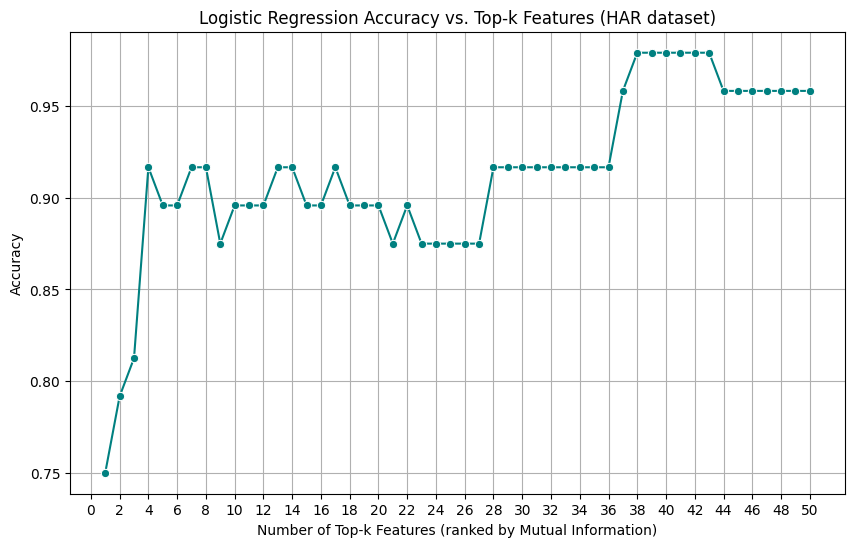

Best accuracy: 0.979 with top 38 features.


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif

# ----------------------------------------------------------------------------
# Step 0: Load your filtered features (after variance/correlation filtering)
# ----------------------------------------------------------------------------
df = pd.read_csv("features_filtered.csv")   # or "features.csv"
meta_cols = ["activity", "trial", "student", "window_idx"]

X = df.drop(columns=[c for c in meta_cols if c in df.columns], errors="ignore")
y = df["activity"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ----------------------------------------------------------------------------
# Step 0.5: Scale Features (important for logistic regression stability)
# ----------------------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# ----------------------------------------------------------------------------
# Step 1: Compute Mutual Information Scores
# ----------------------------------------------------------------------------
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)
feature_ranking = np.argsort(mi_scores)[::-1]  # indices of features sorted by MI

# ----------------------------------------------------------------------------
# Step 2: Evaluate Logistic Regression with Top-k Features
# ----------------------------------------------------------------------------
total_features = X_train.shape[1]
accuracy_list = []

for k in range(1, total_features + 1):
    top_k_features = X_train_scaled.columns[feature_ranking[:k]]
    model = LogisticRegression(max_iter=5000, random_state=42, multi_class="multinomial")
    model.fit(X_train_scaled[top_k_features], y_train)
    y_pred = model.predict(X_test_scaled[top_k_features])
    acc = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc)

# ----------------------------------------------------------------------------
# Step 3: Plot Accuracy vs. Number of Features
# ----------------------------------------------------------------------------
plt.figure(figsize=(10,6))
sns.lineplot(
    x=range(1, total_features + 1),
    y=accuracy_list,
    marker="o",
    color="teal"
)
plt.xlabel("Number of Top-k Features (ranked by Mutual Information)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy vs. Top-k Features (HAR dataset)")
plt.xticks(range(0, total_features + 1, max(1, total_features // 20)))
plt.grid(True)
plt.show()

# ----------------------------------------------------------------------------
# Step 4 (Optional): Print best k
# ----------------------------------------------------------------------------
best_k = np.argmax(accuracy_list) + 1
print(f"Best accuracy: {max(accuracy_list):.3f} with top {best_k} features.")


c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning

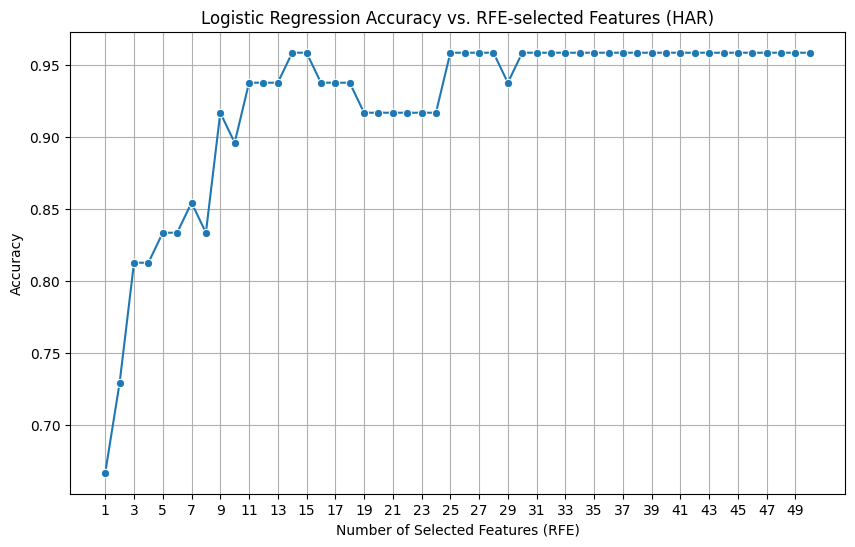

Best accuracy = 0.958 with top 14 features.


In [35]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# --------------------------------------------------------------------
# 0) Load your HAR features
# --------------------------------------------------------------------
df = pd.read_csv("features_filtered.csv")          # or features_filtered.csv
meta_cols = ["activity", "trial", "student", "window_idx"]
X = df.drop(columns=[c for c in meta_cols if c in df.columns], errors="ignore")
y = df["activity"]

# Train/Test split (stratify by activity)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --------------------------------------------------------------------
# 0.5) Scale features (important for Logistic Regression)
# --------------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

# --------------------------------------------------------------------
# 1) RFE curve: accuracy vs number of selected features
#    Note: RFE is expensive if you run it for every k. To keep it reasonable:
#      - set MAX_K (cap)
#      - use step>1 (remove multiple features each iteration)
# --------------------------------------------------------------------
total_features = X_train_scaled.shape[1]
MAX_K = min(total_features, 150)   # cap to speed things up (tune as you like)
STEP  = 0.1                        # can be int (e.g., 5) or fraction (10% per step)

k_values = list(range(1, MAX_K + 1))
rfe_accuracy_list = []

for k in k_values:
    # base estimator (multiclass)
    base_model = LogisticRegression(
        max_iter=5000,
        random_state=42,
        multi_class="multinomial",
        solver="lbfgs"
    )

    # RFE to select top-k features
    selector = RFE(estimator=base_model, n_features_to_select=k, step=STEP)
    selector.fit(X_train_scaled, y_train)

    # selected features
    selected_cols = X_train_scaled.columns[selector.support_]

    # retrain on selected cols and evaluate
    base_model.fit(X_train_scaled[selected_cols], y_train)
    y_pred = base_model.predict(X_test_scaled[selected_cols])
    acc = accuracy_score(y_test, y_pred)
    rfe_accuracy_list.append(acc)

# --------------------------------------------------------------------
# 2) Plot
# --------------------------------------------------------------------
plt.figure(figsize=(10,6))
sns.lineplot(x=k_values, y=rfe_accuracy_list, marker="o")
plt.xlabel("Number of Selected Features (RFE)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy vs. RFE-selected Features (HAR)")
plt.grid(True)
# fewer ticks if many features
if len(k_values) > 40:
    step = max(1, len(k_values)//20)
    plt.xticks(k_values[::step])
plt.show()

# Best k
best_k = k_values[int(np.argmax(rfe_accuracy_list))]
print(f"Best accuracy = {max(rfe_accuracy_list):.3f} with top {best_k} features.")


In [36]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

base_model = LogisticRegression(max_iter=5000, solver="lbfgs", multi_class="multinomial")
rfecv = RFECV(estimator=base_model, step=STEP, cv=StratifiedKFold(5),
              scoring="accuracy", n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

print("Optimal number of features:", rfecv.n_features_)
best_features = X_train_scaled.columns[rfecv.support_]
print("Best features:", best_features.tolist())


Optimal number of features: 40
Best features: ['accelerometer_y_var', 'accelerometer_y_range', 'accelerometer_z_var', 'accelerometer_z_min', 'gyroscope_y_range', 'gravity_y_median', 'gravity_z_min', 'gravity_y_max', 'gyroscope_x_range', 'gravity_z_max', 'gyroscope_z_range', 'gravity_z_rms', 'gravity_z_range', 'gravity_x_min', 'accelerometer_z_iqr', 'gravity_y_rms', 'accelerometer_mag_iqr', 'gravity_y_range', 'gravity_x_max', 'gravity_y_var', 'gyroscope_z_max', 'gyroscope_y_min', 'gyroscope_sma', 'gyroscope_x_max', 'gyroscope_z_min', 'gravity_y_iqr', 'gyroscope_mag_var', 'gyroscope_x_var', 'gravity_mag_fft_dom_freq_hz', 'gyroscope_x_iqr', 'gravity_yz_corr', 'gyroscope_z_iqr', 'gyroscope_mag_spec_entropy', 'gyroscope_mag_iqr', 'accelerometer_y_mean', 'accelerometer_z_median', 'gyroscope_x_fft_dom_mag', 'gyroscope_z_mean', 'gyroscope_z_median', 'gyroscope_mag_fft_dom_mag']


c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning

In [37]:
import pandas as pd

# Meta columns
META_COLS = ["activity", "trial", "student", "window_idx"]

# Optimal features from RFECV (directly from the model)
best_features = X_train_scaled.columns[rfecv.support_].tolist()
print("Best features:", best_features)

# Load full dataset (unscaled, with metadata)
df = pd.read_csv("features.csv")

# Keep meta + best features
cols_to_keep = [c for c in META_COLS if c in df.columns] + best_features
df_optimal = df[cols_to_keep]

# Save to new CSV
df_optimal.to_csv("optimal_features.csv", index=False)
print(f"Saved optimal_features.csv with shape {df_optimal.shape}")


Best features: ['accelerometer_y_var', 'accelerometer_y_range', 'accelerometer_z_var', 'accelerometer_z_min', 'gyroscope_y_range', 'gravity_y_median', 'gravity_z_min', 'gravity_y_max', 'gyroscope_x_range', 'gravity_z_max', 'gyroscope_z_range', 'gravity_z_rms', 'gravity_z_range', 'gravity_x_min', 'accelerometer_z_iqr', 'gravity_y_rms', 'accelerometer_mag_iqr', 'gravity_y_range', 'gravity_x_max', 'gravity_y_var', 'gyroscope_z_max', 'gyroscope_y_min', 'gyroscope_sma', 'gyroscope_x_max', 'gyroscope_z_min', 'gravity_y_iqr', 'gyroscope_mag_var', 'gyroscope_x_var', 'gravity_mag_fft_dom_freq_hz', 'gyroscope_x_iqr', 'gravity_yz_corr', 'gyroscope_z_iqr', 'gyroscope_mag_spec_entropy', 'gyroscope_mag_iqr', 'accelerometer_y_mean', 'accelerometer_z_median', 'gyroscope_x_fft_dom_mag', 'gyroscope_z_mean', 'gyroscope_z_median', 'gyroscope_mag_fft_dom_mag']
Saved optimal_features.csv with shape (160, 44)
